# Homework - Analysis of movement patterns


## Introduction 
In this homework you are going to analyze the movement patterns of a vehicle. 
The overall goal is to assign the vehicle to one of the following three operation purposes: Taxi, Craftman, Truck
In detail perform the following tasks:
1. filter the GPS data of the given dataset.


## Preparation
First of all we need to import all necessary packages and modules:
* pandas (pandas dataframes)
* geopandas (geopandas dataframes)
* numpy (numpy arrays as well as various mathematical methods)
* matplotlib.pyplot (plotting)
* pickle (importing data)

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%run ./data/custom_functions.py

Further, we want to set the font size of all plot globally. 

In [2]:
plt.rcParams.update({'font.size': 16})

## Given functions

In [3]:
'''
DISCRIPTION: Function to calculate distance between two GPS points
INPUT: latitude (scalar) and longitutde (scalar) of both points 
OUTPUT: distance (scalar) in m
'''
def lat_lon_2_m(latitude_1, longitude_1, latitude_2, longitude_2):
    # Radius of the earth in km
    radius_earth = 6371009

    d_latitude = np.deg2rad(latitude_2 - latitude_1)
    d_longitude = np.deg2rad(longitude_2 - longitude_1)
    latitude_1 = np.deg2rad(latitude_1)
    latitude_2 = np.deg2rad(latitude_2)

    a = (np.sin(d_latitude / 2)) ** 2 + np.cos(latitude_1) * np.cos(latitude_2) * (np.sin(d_longitude / 2)) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = radius_earth * c

    return distance


'''
DISCRIPTION: Function to calculate time step between two consecutive timestamps
INPUT: time (np array(datetime64)) 
OUTPUT: time_step (np array(scalar)) 
'''
def calculate_time_step(time):

    # initialize distance array
    time_step = np.zeros(len(time))

    # loop latitude, longitude
    for i in range(0, len(time) - 1):

        # calculate time difference
        dt = (time[i + 1] - time[i]) / np.timedelta64(1, 's')

        # check for new track
        if dt > 10:
            dt = 0

        # append distance to array
        time_step[i] = dt

    return time_step


'''
DISCRIPTION: Function to calculate speed distribution 
INPUT: time_step (np array(scalar))  and speed (np array(scalar)) 
OUTPUT: v_0_30 (scalar), v_30_50(scalar) and v_50_inf (scalar)
'''
def calculate_speed_distribution(time_step, speed):

    if len(time_step) != len(speed):
        return np.nan, np.nan, np.nan

    else:

        # initialize
        v_0_30_duration = 0
        v_30_50_duration = 0
        v_50_inf_duration = 0

        # calculate total duration
        total_duration = time_step.sum()

        # scale speed to km/h
        speed_kmh = 3.6 * speed

        # loop distance
        for i in range(0, len(time_step) - 1):

            if (speed_kmh[i] < 30):
                v_0_30_duration += time_step[i]
            elif (speed_kmh[i] >= 30) & (speed_kmh[i] <= 50):
                v_30_50_duration += time_step[i]
            else:
                v_50_inf_duration += time_step[i]

        # scale to total distance
        v_0_30 = v_0_30_duration / total_duration
        v_30_50 = v_30_50_duration / total_duration
        v_50_inf = v_50_inf_duration / total_duration

        return v_0_30, v_30_50, v_50_inf

    
'''
# DISCRIPTION: Function to calculate the relative positive acceleration
# INPUT: acceleration (np array(scalar)), speed (np array(scalar)), time_step (np array(scalar)) and distance (np array(scalar)) 
# OUTPUT: rpa (scalar)
'''
def calculate_relative_positive_acceleration(acceleration, speed, time_step, distance):

    if len(distance) != len(speed) != len(acceleration) != len(time_step):
        return np.nan

    else:

        # initialize rpa
        rpa_sum = 0

        # calculate total distance
        total_distance = distance.sum()

        # loop distance
        for i in range(0, len(acceleration) - 1):

            if acceleration[i] > 0:

                rpa_sum += (time_step[i] * speed[i] * acceleration[i])

        # scale to total distance
        rpa = rpa_sum / total_distance

        return rpa


'''
DISCRIPTION: Function to calculate the acceleration
INPUT: speed (np array(scalar)), time_step (np array(scalar))
OUTPUT: acceleration (np array(scalar))
'''
def calculate_acceleration(speed, time_step):

    if len(speed) != len(time_step):
        return np.nan

    else:

        # initialize acceleration array
        acceleration = np.zeros(len(speed))

        # loop latitude, longitude
        for i in range(0, len(speed) - 1):

            # calculate acceleration between two consecutive points
            if time_step[i] != 0:
                acc = (speed[i + 1] - speed[i]) / time_step[i]
            else:
                acc = 0

            # append acceleration to array
            acceleration[i] = acc

        return acceleration
    
# DISCRIPTION: Plots data of a data frame with a color value of your choice. Limit is 6500 points
# INPUT: 
    # pos_data: dataframe containing all data (positions and extra)
    # colorvalue: name of the colum of the dataframe, the coulor value should be mapped
    # geometry: (optional) Geometry column of the dateframe. default is 'geom' 
    # c_min: (optional) min value the colorbar should be mapped to. default is -1 = auto
    # c_max: (optional) max value the colorbar should be mapped to. default is -1 = auto
    # line: (optional) connect points in rendering. Default is False
    # cm_type: (optional) define the colormap beeing used. default is 'jet'
# OUTPUT: interactive folium map
# map_folium(pos_data, colorvalue, geometry = 'geom', c_min = -1, c_max = -1, line = False, cm_type='jet'):

## Filtering
Filter the data for each vehicle. Perform following actions:
1. Remove points with no significant velocity in range.
2. Remove points with bad GPS signal. Identify a reasonable treshold value.
3. Prepare the data per vehicle per day. Include a day column and provide distance and acceleration for each point. Keep an eye on track starts and ends.

In [4]:
# function to calculate distance of point series
def calculate_distance(points):
    # initialize distance array
    distance = np.zeros(len(points))
    # loop all points
    for i in range(0, len(points) - 1):
        # calculate distance between two consecutive points using lat_lon_2_km function
        d = lat_lon_2_m(
            points[i].x,
            points[i].y,
            points[i+1].x,
            points[i+1].y,)
        # append distance to array
        distance[i + 1] = d
    return distance

In [5]:
data = pd.read_pickle('data/data_homework.p')
display(data)

,time,latitude,longitude,altitude,course,hdop,vdop,speed,geom
0,2017-10-10 17:02:07,48.142916,11.571085,579.0,0.0,97.0,0.0,0.0,POINT (11.571085 48.142916)
1,2017-10-10 17:02:08,48.142970,11.571044,577.0,0.0,93.0,0.0,0.0,POINT (11.571044 48.14297)
2,2017-10-10 17:02:09,48.142965,11.571052,581.0,0.0,91.0,0.0,0.0,POINT (11.571052 48.142965)
3,2017-10-10 17:02:10,48.142896,11.571106,585.0,0.0,90.0,0.0,0.0,POINT (11.571106 48.142896)
4,2017-10-10 17:02:11,48.142903,11.571103,587.0,0.0,92.0,0.0,0.0,POINT (11.571103 48.142903)
...,...,...,...,...,...,...,...,...,...
439379,2018-01-25 11:54:13,48.257070,12.546113,452.0,0.0,3.0,0.0,0.0,POINT (12.546113 48.25707)
439380,2018-01-25 11:54:14,48.257070,12.546113,452.0,0.0,3.0,0.0,0.0,POINT (12.546113 48.25707)
439381,2018-01-25 11:54:15,48.257070,12.546113,452.0,0.0,3.0,0.0,0.0,POINT (12.546113 48.25707)
439382,2018-01-25 11:54:16,48.257070,12.546113,452.0,0.0,3.0,0.0,0.0,POINT (12.546113 48.25707)


In [6]:
# calculate time difference (name it time_diff) between points using pandas.shift() function
# calculate distance between a point and the one following in meter (name it distance_diff)
data['time_diff'] = data.time-data.time.shift(1,fill_value = 0)
data['distance_diff'] = calculate_distance(data.geom)

data['acceleration'] = (data.speed-data.speed.shift())/(data.time_diff.dt.total_seconds())
# for comparison get the speed and acceleration values from the positions and thime between them
data['speed_calc'] = (data.distance_diff/(data.time_diff.dt.total_seconds()))

In [7]:
display(data)

,time,latitude,longitude,altitude,course,hdop,vdop,speed,geom,time_diff,distance_diff,acceleration,speed_calc
0,2017-10-10 17:02:07,48.142916,11.571085,579.0,0.0,97.0,0.0,0.0,POINT (11.571085 48.142916),17449 days 17:02:07,0.000000,NaN,0.000000
1,2017-10-10 17:02:08,48.142970,11.571044,577.0,0.0,93.0,0.0,0.0,POINT (11.571044 48.14297),0 days 00:00:01,7.442332,0.0,7.442332
2,2017-10-10 17:02:09,48.142965,11.571052,581.0,0.0,91.0,0.0,0.0,POINT (11.571052 48.142965),0 days 00:00:01,1.043068,0.0,1.043068
3,2017-10-10 17:02:10,48.142896,11.571106,585.0,0.0,90.0,0.0,0.0,POINT (11.571106 48.142896),0 days 00:00:01,9.620430,0.0,9.620430
4,2017-10-10 17:02:11,48.142903,11.571103,587.0,0.0,92.0,0.0,0.0,POINT (11.571103 48.142903),0 days 00:00:01,0.832320,0.0,0.832320
...,...,...,...,...,...,...,...,...,...,...,...,...,...
439379,2018-01-25 11:54:13,48.257070,12.546113,452.0,0.0,3.0,0.0,0.0,POINT (12.546113 48.25707),0 days 00:00:01,0.108540,0.0,0.108540
439380,2018-01-25 11:54:14,48.257070,12.546113,452.0,0.0,3.0,0.0,0.0,POINT (12.546113 48.25707),0 days 00:00:01,0.000000,0.0,0.000000
439381,2018-01-25 11:54:15,48.257070,12.546113,452.0,0.0,3.0,0.0,0.0,POINT (12.546113 48.25707),0 days 00:00:01,0.000000,0.0,0.000000
439382,2018-01-25 11:54:16,48.257070,12.546113,452.0,0.0,3.0,0.0,0.0,POINT (12.546113 48.25707),0 days 00:00:01,0.000000,0.0,0.000000


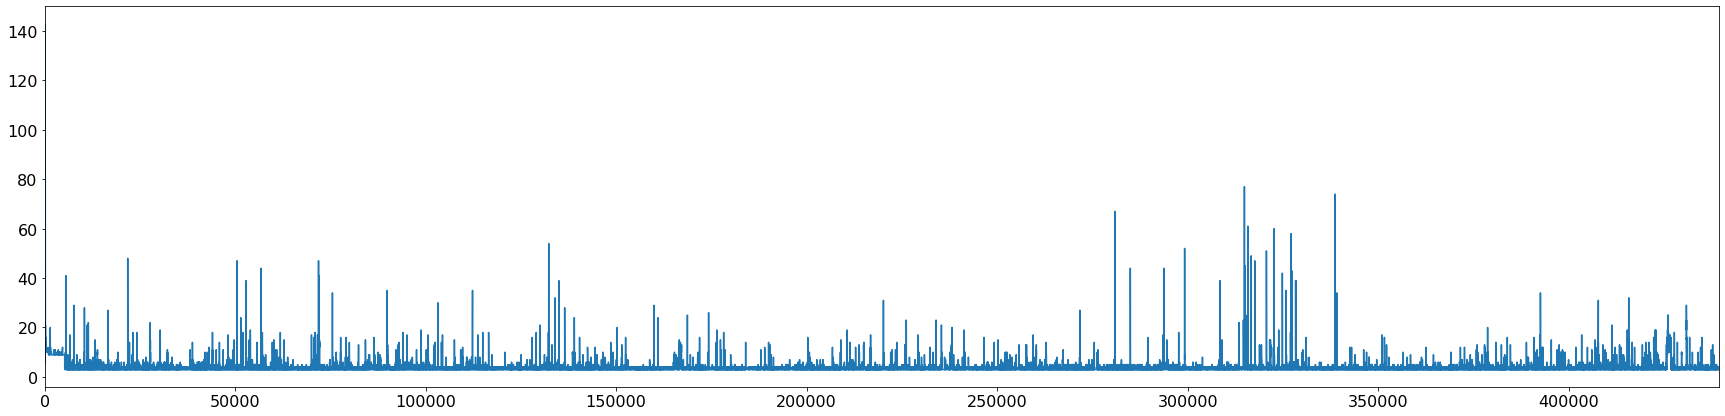

In [8]:
data.hdop.plot(figsize = (30,7))

In [9]:
# filter speed
speed_thr = 0.1 # m/s
data['speed_median']= data['speed'].rolling(3).median()
#filter data by speed treshold
data = data[data.speed_median > speed_thr]

# filter hdop
hdop_thr = 20
data = data[data.hdop < hdop_thr]

data =data.reset_index(drop=True)
data['distance_diff'] = calculate_distance(data.geom)
data['time_diff'] = data.time-data.time.shift(1,fill_value = 0)
data['speed_calc'] = (data.distance_diff/(data.time_diff.dt.total_seconds()))
#data['acceleration_calc'] = (data.speed_calc-data.speed_calc.shift(1))/(data.time_diff.dt.total_seconds())
data['acceleration'] = (data.speed-data.speed.shift())/(data.time_diff.dt.total_seconds())

In [10]:
display(data)

,time,latitude,longitude,altitude,course,hdop,vdop,speed,geom,time_diff,distance_diff,acceleration,speed_calc,speed_median
0,2017-10-23 14:12:19.464,48.257485,12.545987,448.0,2.3,17.0,0.0,1.58,POINT (12.545987 48.257485),17462 days 14:12:19.464000,0.000000,NaN,0.000000,1.58
1,2017-10-23 14:12:20.464,48.257433,12.546005,451.0,0.0,8.0,0.0,0.00,POINT (12.546005 48.257433),0 days 00:00:01,5.988461,-1.580000,5.988461,1.58
2,2017-10-23 14:18:00.493,48.257407,12.546071,463.0,28.1,8.0,0.0,0.56,POINT (12.546071 48.257407),0 days 00:05:40.029000,7.862760,0.001647,0.023124,0.56
3,2017-10-23 14:18:01.494,48.257444,12.546034,455.0,0.0,7.0,0.0,0.00,POINT (12.546034 48.257444),0 days 00:00:01.001000,5.749336,-0.559441,5.743593,0.56
4,2017-10-23 14:32:14.000,48.257399,12.546016,450.0,133.3,3.0,0.0,0.75,POINT (12.546016 48.257399),0 days 00:14:12.506000,5.278486,0.000880,0.006192,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383521,2018-01-25 11:53:58.000,48.257121,12.546061,452.0,105.9,4.0,0.0,0.75,POINT (12.546061 48.257121),0 days 00:00:01,1.544052,-0.750000,1.544052,1.25
383522,2018-01-25 11:53:59.000,48.257104,12.546074,452.0,149.3,4.0,0.0,1.00,POINT (12.546074 48.257104),0 days 00:00:01,2.343984,0.250000,2.343984,1.00
383523,2018-01-25 11:54:00.000,48.257089,12.546084,452.0,155.9,3.0,0.0,1.00,POINT (12.546084 48.257089),0 days 00:00:01,1.971583,0.000000,1.971583,1.00
383524,2018-01-25 11:54:01.000,48.257083,12.546092,452.0,155.9,4.0,0.0,0.25,POINT (12.546092 48.257083),0 days 00:00:01,1.102466,-0.750000,1.102466,1.00


In [11]:
# This is the same code as the turorial. just execute it.
tracks = pd.DataFrame(columns=['time_start','time_stop', 'duration', 'date', 'distance','avg_speed'])
tracks['time_start'] = data[data.time_diff > np.timedelta64(5, 'm')].time
tracks['time_stop'] = data.iloc[tracks.index-1].time.sort_values().values
tracks['duration'] = tracks.time_stop- tracks.time_start
tracks = tracks[tracks.duration > np.timedelta64(30, 's')]

tracks.reset_index(drop = True, inplace=True)
tracks['date'] = tracks.time_start.apply(lambda x: x.date())
for i, row in tracks.iterrows():
        tracks.distance.iloc[i] = data[(data.time > tracks.iloc[i].time_start)&(data.time <= tracks.iloc[i].time_stop)].distance_diff.sum()/1000
tracks['avg_speed'] = tracks.distance/(tracks.duration.dt.total_seconds()/3600)

def generate_daily_driving(data, tracks):
    trackdata =[]
    for i, row in tracks.iterrows():
        trackdata.insert(i,[tracks.iloc[i].date, [data[['time', 'geom', 'speed', 'time_diff', 'distance_diff', 'acceleration']][(data.time >= tracks.iloc[i].time_start)&(data.time <= tracks.iloc[i].time_stop)]]])
    return trackdata
    
trackdata = generate_daily_driving(data, tracks)
pickle.dump( trackdata, open( "trackdata.p", "wb" ))

display(tracks)

/home/ge54seq/.local/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,time_start,time_stop,duration,date,distance,avg_speed
0,2017-10-23 14:32:14.000,2017-10-23 14:37:05,00:04:51,2017-10-23,0.610632,7.55421
1,2017-10-23 14:42:18.000,2017-10-23 14:52:05,00:09:47,2017-10-23,0.494924,3.03531
2,2017-10-23 15:04:51.000,2017-10-23 15:28:28,00:23:37,2017-10-23,17.0926,43.425
3,2017-10-23 16:55:54.000,2017-10-23 17:43:48,00:47:54,2017-10-23,44.0914,55.2294
4,2017-10-24 06:15:49.000,2017-10-24 06:36:38,00:20:49,2017-10-24,17.875,51.5213
...,...,...,...,...,...,...
318,2018-01-22 05:07:17.000,2018-01-22 05:08:46,00:01:29,2018-01-22,0.276121,11.1689
319,2018-01-22 16:53:55.000,2018-01-22 16:59:36,00:05:41,2018-01-22,4.90763,51.8108
320,2018-01-22 17:23:37.000,2018-01-22 17:45:33,00:21:56,2018-01-22,28.668,78.423
321,2018-01-25 10:44:35.000,2018-01-25 11:12:05,00:27:30,2018-01-25,31.4242,68.5619


In [12]:
display(tracks[tracks.distance < 0.1])

,time_start,time_stop,duration,date,distance,avg_speed
37,2017-11-07 13:43:16,2017-11-07 13:44:18,00:01:02,2017-11-07,0.074823,4.34456
291,2018-01-21 16:19:56,2018-01-21 16:20:29,00:00:33,2018-01-21,0.0787606,8.59207


In [13]:
# reset track view counter
track_no = 0

In [14]:
# Plot a single Track on a map, show next track when executing again
if track_no >= tracks.shape[0]: 
    track_no=0
    print("Restart")
my_track = data[(data.time > tracks.time_start[track_no]) & (data.time < tracks.time_stop[track_no])]
print("Track No. " + str(track_no) + " Duration: " + str(tracks.duration[track_no]))
track_no += 1
map_folium(my_track, 'speed' , line=True)

Track No. 0 Duration: 0 days 00:04:51
Rendering 90 Points


In [15]:
#to be shure to get everything right, use this checkpoint data.
location_lst = pickle.load( open( "trackdata.p", "rb" ))

In [16]:
display(location_lst)

[[datetime.date(2017, 10, 23),
  [                  time                         geom  speed       time_diff  \
   4  2017-10-23 14:32:14  POINT (12.546016 48.257399)   0.75 00:14:12.506000   
   5  2017-10-23 14:32:15   POINT (12.546018 48.25738)   1.25        00:00:01   
   6  2017-10-23 14:32:16  POINT (12.546025 48.257371)   1.25        00:00:01   
   7  2017-10-23 14:32:17  POINT (12.546026 48.257365)   1.00        00:00:01   
   8  2017-10-23 14:32:18  POINT (12.546021 48.257347)   0.75        00:00:01   
   ..                 ...                          ...    ...             ...   
   91 2017-10-23 14:33:43  POINT (12.545693 48.256926)   1.75        00:00:01   
   92 2017-10-23 14:33:44  POINT (12.545702 48.256924)   0.75        00:00:01   
   93 2017-10-23 14:33:45  POINT (12.545706 48.256926)   0.00        00:00:01   
   94 2017-10-23 14:37:03  POINT (12.545775 48.256914)   0.50        00:03:18   
   95 2017-10-23 14:37:05  POINT (12.545726 48.256919)   0.00        00:00:02 

## Homework 3.2 Calculate metadata per day

### Task
First of all we need to calculate the metadata per day in order to proceed with the analysis: The metadata is given by:
* Daily distance in m
* Discrete distribution of speed per day according to the speed intervals ]2, 30[, [2, 30] and ]30, $\infty$[
* Relative positive acceleration (RPA) in m/s^2 per day

Further, we want to store the metadata per day in a dataframe called metadata_df. The dataframe should have the following structure:<br/>
metadata_df = pd.DataFrame(columns=['day', 'distance', 'v_0_30', 'v_30_50', 'v_50_inf', 'rpa'])

##### Signature of the script
The signature of the script definies the interfaces (INPUT, OUTPUT) of the current task within this notebook. It is up to you, how you get from INPUT to OUTPUT.
* INPUT: Pandas dataframe data_df
* OUPUT: Pandas dataframe metadata_df

### Your code here:

In [19]:
# retrieve all meta-information per day and save it into a dataframe
def calculateMetadataPerDay(data_df, debug=False):
    '''
    Arguments:
    data_df -- origin data dataframe of every instance
    debug -- flag of whether display the success message for every day, type bool, default False
    
    Returns:
    metadata_df -- dataframe of retrieved meta-information, including ['day', 'distance', 'v_0_30', 'v_30_50', 'v_50_inf', 'rpa']
    '''
    
    # initialize metadata dataframe
    metadata_df = pd.DataFrame(columns=['day', 'distance', 'v_0_30', 'v_30_50', 'v_50_inf', 'rpa'])
    
    # store the rows of data_df of one day
    data_df_oneday = pd.DataFrame()
    
    # store the first day, will be updated every day
    day = data_df.iloc[0].time.date()
    
    # loop for every row of data_df, retrieve information every day
    for i, row in data_df.iterrows():        
        # decide whether there is a new day or the end
        if (data_df.iloc[i].time.date() != day) or (i == len(data_df)-1):
            # retrieve the information of distance
            distance = data_df_oneday.distance_diff.sum()/1000
            
            # retrieve the information of time_step using the given function
            time_step = calculate_time_step(data_df_oneday.time)
            
            # retrieve the informaiton of speed distribution using the given function
            v_0_30, v_30_50, v_50_inf = calculate_speed_distribution(time_step, data_df_oneday.speed)
            
            # retrieve the information of rpa using the given function
            rpa = calculate_relative_positive_acceleration(data_df_oneday.acceleration, data_df_oneday.speed, time_step, data_df_oneday.distance_diff)
            
            # append all information into metadata_df
            metadata_df = metadata_df.append({'day':day, 
                                              'distance':distance, 
                                              'v_0_30':v_0_30, 
                                              'v_30_50':v_30_50, 
                                              'v_50_inf':v_50_inf, 
                                              'rpa':rpa}, ignore_index=True)
            
            if debug:
                # print success message
                print(str(day) + ' success!')
            
            # reset the new day
            day = data_df.iloc[i].time.date()
            
            # reset data_df_oneday
            data_df_oneday = pd.DataFrame()
        
        # store rows of data_df of one day
        data_df_oneday = data_df_oneday.append(row, ignore_index=True)
        
    return metadata_df
    

In [20]:
metadata_df = calculateMetadataPerDay(data)
display(metadata_df)

,day,distance,v_0_30,v_30_50,v_50_inf,rpa
0,2017-10-23,62.321452,0.427784,0.269695,0.302521,0.138400
1,2017-10-24,19.051946,0.185990,0.194444,0.619565,0.107455
2,2017-10-26,257.996891,0.082148,0.110098,0.807754,0.134181
3,2017-10-28,198.423127,0.199163,0.184351,0.616486,0.133622
4,2017-10-29,38.577547,0.194253,0.179310,0.626437,0.127707
...,...,...,...,...,...,...
77,2018-01-19,98.063766,0.327113,0.274257,0.398630,0.097124
78,2018-01-20,163.165902,0.136105,0.277654,0.586241,0.109012
79,2018-01-21,286.285586,0.358544,0.267805,0.373651,0.154662
80,2018-01-22,171.224264,0.294730,0.262639,0.442631,0.127041


## Data import
Here the daily distances of various vehicles related to each operation purpose is imported and saved as a numpy array using pandas read_pickle function. 

In [21]:
daily_distance_craftman = pd.read_pickle('data/daily_distance_craftman_df.pkl').values
daily_distance_taxi = pd.read_pickle('data/daily_distance_taxi_df.pkl').values
daily_distance_truck = pd.read_pickle('data/daily_distance_truck_df.pkl').values

## Homework 3.3 Write a function that calculates the CDF 

### Task
Since we will need to calculate the CDF a couple of times, we want to write a function for this purpose. 
1. Write a function, that calculate the CDF. Use 1000 bins for the calculation.

##### Signature of the function
The signature of the script definies the interfaces (INPUT, OUTPUT) of the current task within this notebook. It is up to you, how you get from INPUT to OUTPUT.
* INPUT: daily_distance as numpy array
* OUPUT: cdf values and bin_edges as numpy arrays

### Your code here:

In [22]:
# calculate CDF of the given array of daily_distance
def calculateCDF(daily_distance):
    '''
    Arguments:
    daily_distance -- numpy array of distance traveled every day
    
    Returns:
    cdf -- numpy array of cdf
    bin_edges -- numpy array of bin_edges
    '''
    
    hist, bin_edges = np.histogram(daily_distance, bins=1000, density=True)
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    
    return cdf, bin_edges


only for test


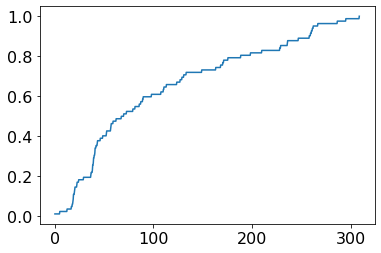

In [23]:
cdf, bin_edges = calculateCDF(metadata_df.distance)
print('only for test')
plt.plot(bin_edges[1:], cdf)

## Homework 3.4 Analyse the daily distance

### Task
1. Calculate the CDFs of the daily distances of your vehicle as well as of the vehicles related to each operation purpose using your function from 5.2
2. Visualize the resulting CDFs in one plot. Use the pyplot's line-function. Do not forget to include a legend, axis lables as well as an appropriate title in your plot. 

##### Signature of the script
The signature of the script definies the interfaces (INPUT, OUTPUT) of the current task within this notebook. It is up to you, how you get from INPUT to OUTPUT.
* INPUT: metadata_df as pandas dataframe
* OUPUT: one plot 

### Your code here:

In [24]:
# calculate all CDFs for unknown vehicle, craftman, taxi and truck, and plot them in the same plot
def plotCDF(**daily_distance):
    '''
    Arguments:
    **daily_distance -- input dictionary of daily distance
    
    Returns:
    None
    '''
    
    plt.figure(figsize=(12, 8))
    axes = plt.gca()
    
    # store the maximum of all daily distance, to determine the max of x axis
    maxDailyDistance = 0
    
    for key, value in daily_distance.items():
        # calculate CDF and plot it
        cdf, bin_edges = calculateCDF(value)
        plt.plot(bin_edges[1:], cdf, label='CDF_'+key)
        
        if max(value) > maxDailyDistance:
            maxDailyDistance = max(value)
    
    plt.title('CDF Graphs of all')    
    plt.xlabel('Daily Distance in km')
    plt.ylabel('Cumulative Relative Frequency')
    
    axes.set_xlim([0, maxDailyDistance])
    axes.set_ylim([0, 1])
    plt.grid(b=True)
    plt.legend()
    
    plt.show()
    

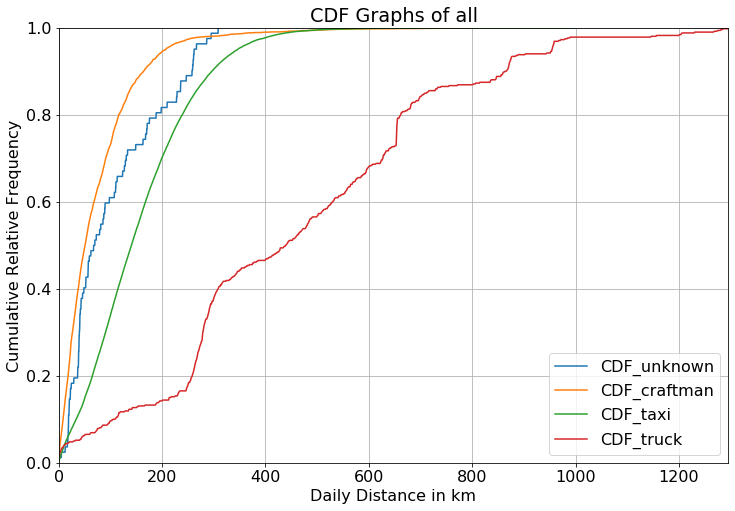

In [25]:
plotCDF(unknown=metadata_df.distance, 
        craftman=daily_distance_craftman/1000, 
        taxi=daily_distance_taxi/1000, 
        truck=daily_distance_truck/1000)

## Data import
Here the speed distributions of various vehicles related to each operation purpose is imported and saved as a numpy array using pandas read_pickle function. 

In [26]:
# read data
speed_distribution_craftman_df = pd.read_pickle('data/speed_distribution_craftman_df.pkl')
speed_distribution_taxi_df = pd.read_pickle('data/speed_distribution_taxi_df.pkl')
speed_distribution_truck_df = pd.read_pickle('data/speed_distribution_truck_df.pkl')

v_0_30_craftman = speed_distribution_craftman_df['v_0_30'].values
v_0_30_taxi = speed_distribution_taxi_df['v_0_30'].values
v_0_30_truck = speed_distribution_truck_df['v_0_30'].values

v_30_50_craftman = speed_distribution_craftman_df['v_30_50'].values
v_30_50_taxi = speed_distribution_taxi_df['v_30_50'].values
v_30_50_truck = speed_distribution_truck_df['v_30_50'].values

## Homework 3.5 Write a function that calculates the mean values of a discrete speed distribution

### Task
Since we will need to calculate the mean values of the discrete speed distribution a couple of times, we want to write a function for this purpose. 
1. Write a function, that calculate the mean values of a speed distribution. 

##### Signature of the function
The signature of the script definies the interfaces (INPUT, OUTPUT) of the current task within this notebook. It is up to you, how you get from INPUT to OUTPUT.
* INPUT: v_0_30, v_30_50 as numpy array
* OUPUT: v_0_30_mean, v_30_50_mean, v_50_inf_mean as numpy arrays

##### Hint
* v_50_inf_mean results from v_0_30, v_30_50, since the mean value must sum to 1

### Your code here:

In [27]:
# calculate the mean values of discrete speed distribution
def calculateMeanValuesOfDiscreteSpeedDistribution(v_0_30, v_30_50):
    '''
    Arguments:
    v_0_30 -- numpy array of speed distribution from 0 to 30 km/h
    v_30_50 -- numpy array of speed distribution from 30 to 50 km/h
    
    Returns:
    meanSpeedDistribution -- array of mean speed distribution, store the results
    '''
    
    v_0_30_mean = v_0_30.mean()
    v_30_50_mean = v_30_50.mean()
    v_50_inf_mean = 1 - v_0_30_mean - v_30_50_mean
    
    meanSpeedDistribution = [v_0_30_mean, v_30_50_mean, v_50_inf_mean]
    
    return meanSpeedDistribution


## Homework 3.6 Analyse the discrete speed distribution per day

### Task
1. Calculate the mean values of the discrete speed distributions of your vehicle as well as of the vehicles related to each operation purpose using your function from 5.4
2. Visualize the resulting mean values of your vehicle as well as of the vehicles related to each operation purpose in one plot. Use the pyplot's barh-function. Do not forget to include a legend, axis lables as well as an appropriate title in your plot. 

##### Signature of the script
The signature of the script definies the interfaces (INPUT, OUTPUT) of the current task within this notebook. It is up to you, how you get from INPUT to OUTPUT.
* INPUT: metadata_df as pandas dataframe
* OUPUT: one plot 

### Your code here:

In [28]:
# calculate mean values of discrete speed distribution all all four vehicles, and plot the bar plots horizontally
def plotMeanValuesOfDiscreteSpeedDistribution(**speed):
    '''
    Arguments:
    **speed -- input dictionary of (key:different vehicles, value:dictionary of v_0_30 and v_30_50)
    
    Returns:
    None
    '''

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    
    y = np.arange(3) # position of the first v_0_30 bar, i.e. unknown
    height = 0.2 # height of every bar
    i = 0 # to calculate the position of the rest of v_0_30 bars of other vehicles
    
    for key, value in speed.items():
        # calculate mean speed distribution and plot the bar plots
        meanSpeedDistribution = calculateMeanValuesOfDiscreteSpeedDistribution(value['v_0_30'], value['v_30_50'])
        plt.barh(y+i*height, meanSpeedDistribution, height, label=key)
        i += 1
    
    ax.set_yticks(y+1.5*height)
    ax.set_yticklabels( ('v_0_30_mean', 'v_30_50_mean', 'v_50_inf_mean'))
    
    ax.set(title='Mean Discrete Speed Distribution Bar Plots of all')
    ax.grid(b=True, axis='x')
    ax.legend()


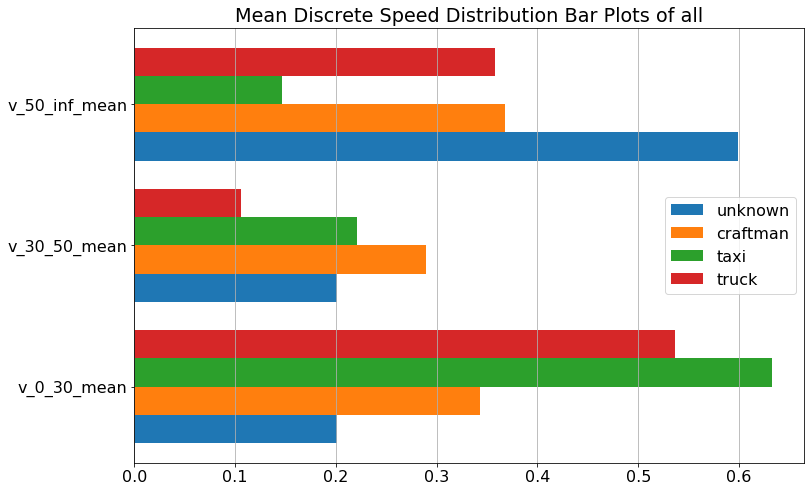

In [29]:
speed_my = {'v_0_30':metadata_df.v_30_50, 'v_30_50':metadata_df.v_30_50}
speed_craftman = {'v_0_30':v_0_30_craftman, 'v_30_50':v_30_50_craftman}
speed_taxi = {'v_0_30':v_0_30_taxi, 'v_30_50':v_30_50_taxi}
speed_truck = {'v_0_30':v_0_30_truck, 'v_30_50':v_30_50_truck}

plotMeanValuesOfDiscreteSpeedDistribution(unknown=speed_my, 
                                          craftman=speed_craftman, 
                                          taxi=speed_taxi, 
                                          truck=speed_truck)

## Data import
Here the RPA of various vehicles related to each operation purpose is imported and saved as a numpy array using pandas read_pickle function. 

In [30]:
# read data
rpa_craftman_df = pd.read_pickle('data/rpa_craftman_df.pkl')
rpa_taxi_df = pd.read_pickle('data/rpa_taxi_df.pkl')
rpa_truck_df = pd.read_pickle('data/rpa_truck_df.pkl')

rpa_craftman = rpa_craftman_df['rpa'].values
rpa_taxi = rpa_taxi_df['rpa'].values
rpa_truck = rpa_truck_df['rpa'].values

## Homework 3.7 Analyse the RPA per day

### Task
1. Visualize the RPA of your vehicle as well as of the vehicles related to each operation purpose in one plot. Use the pyplot's boxplot-function. Do not forget to include a legend, axis lables as well as an appropriate title in your plot. 

##### Signature of the script
The signature of the script definies the interfaces (INPUT, OUTPUT) of the current task within this notebook. It is up to you, how you get from INPUT to OUTPUT.
* INPUT: metadata_df as pandas dataframe
* OUPUT: one plot 

### Your code here:

In [33]:
# plot the box graphs of RPA of all four vehicles
def plotRPA(**rpa):
    '''
    Arguments:
    **rpa -- input dictionary of rpa
    
    Returns:
    None
    '''
    
    fig, ax = plt.subplots(1, 4, figsize=(15,10))
    
    i = 0
    for key, value in rpa.items():
        # plot the box graphs
        ax[i].boxplot(value)
        ax[i].set_ylim([0, 1.3])
        ax[i].grid(b=True, axis='y')
        ax[i].set(title='RPA of '+key)
        i += 1
        
    ax[0].set(ylabel='Relative positive acceleration in m/s^2')
    

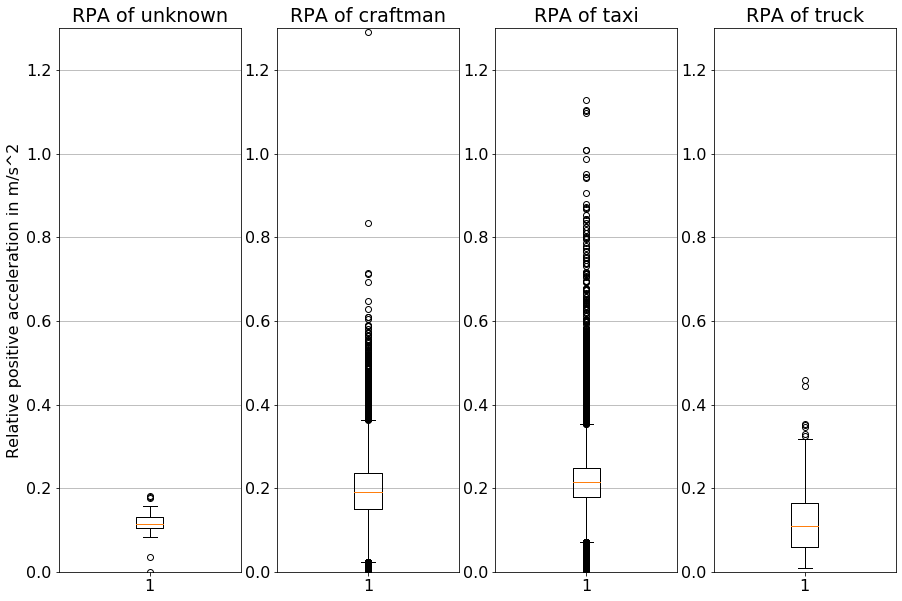

In [34]:
plotRPA(unknown=metadata_df.rpa, 
        craftman=rpa_craftman, 
        taxi=rpa_taxi, 
        truck=rpa_truck)

What kind of vehicle is your vehicle? Please explain your answer in written form!

<font color='red'>
    
# My Answer
    
<font color='black'>

- From the RPA plots we can decide that the given data could be probably from a truck, because it has a relative low RPA, which means it normally accelerate slow. A truck could have such a property.
- From the mean speed distribution bar plots we can see that, this vehicle has a large distribution on v_50_inf, which means it maybe runs most of the time on the highway.
- From the CDF plots we can conclude that, this vehicle may have not so many long journy tasks.

### ps. I like this homework very much! Thanks a lot! It's very interesting!